In [ ]:
import pandas as pd
import json
import glob
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
kick = pd.read_csv('/content/drive/MyDrive/Thesis/Final/kickstarter_dataset_final_thesis.csv')
kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162322 entries, 0 to 162321
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   project_number            162322 non-null  int64  
 1   country_displayable_name  162322 non-null  object 
 2   photo                     162322 non-null  object 
 3   prelaunch_activated       162322 non-null  bool   
 4   staff_pick                162322 non-null  bool   
 5   parent_category           162322 non-null  object 
 6   duration                  162322 non-null  int64  
 7   preparation_days          162322 non-null  int64  
 8   quarter                   162322 non-null  object 
 9   creator_backing_count     162322 non-null  int64  
 10  has_video                 162322 non-null  bool   
 11  goal_usd                  162322 non-null  float64
 12  gender                    162322 non-null  object 
 13  blurb_clean               162322 non-null  o

In [ ]:
kick['gender'].value_counts()

,count
gender,
male,65194
others,59489
female,37639


In [ ]:
log_cols = ['goal_usd', 'preparation_days', 'creator_backing_count']


for col in log_cols:
    kick[f'log_{col}'] = np.log1p(kick[col])

In [ ]:
kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162322 entries, 0 to 162321
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   project_number             162322 non-null  int64  
 1   country_displayable_name   162322 non-null  object 
 2   photo                      162322 non-null  object 
 3   prelaunch_activated        162322 non-null  bool   
 4   staff_pick                 162322 non-null  bool   
 5   parent_category            162322 non-null  object 
 6   duration                   162322 non-null  int64  
 7   preparation_days           162322 non-null  int64  
 8   quarter                    162322 non-null  object 
 9   creator_backing_count      162322 non-null  int64  
 10  has_video                  162322 non-null  bool   
 11  goal_usd                   162322 non-null  float64
 12  gender                     162322 non-null  object 
 13  blurb_clean                16

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score
import warnings
import random

warnings.filterwarnings("ignore")

# ✅ Seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ✅ Features and target
y = kick['state_binary']
feature_cols = [
    'country_displayable_name', 'prelaunch_activated', 'staff_pick',
    'parent_category', 'duration', 'log_preparation_days', 'quarter',
    'log_creator_backing_count', 'has_video', 'log_goal_usd', 'gender',
    'blurb_word_count', 'name_word_count'
]
X = kick[feature_cols].copy()

# ✅ Train/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED
)

# ✅ Preprocessing
numeric_features = [
    'log_goal_usd', 'duration', 'log_preparation_days',
    'log_creator_backing_count', 'blurb_word_count', 'name_word_count'
]
bool_features = ['prelaunch_activated', 'staff_pick', 'has_video']
categorical_features = ['country_displayable_name', 'parent_category', 'gender', 'quarter']

preprocessor = ColumnTransformer([
    ('num',   StandardScaler(),        numeric_features),
    ('bool',  'passthrough',           bool_features),
    ('cat',   OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

# ✅ Model pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=SEED))
])

# ✅ Hyperparameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

# ✅ Nested CV on train_val
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

f1_scores = []
auc_scores = []
best_params_list = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='f1',
        cv=inner_cv,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    print(f"✅ Fold {fold+1}: F1 = {f1:.4f}, AUC = {auc:.4f}")
    f1_scores.append(f1)
    auc_scores.append(auc)
    best_params_list.append(clf.best_params_)

# ✅ CV summary
print("\n⭐ Final Nested CV Results")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average ROC-AUC Score: {np.mean(auc_scores):.4f}")

print("\n📌 Best hyperparameters per fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")

# ——— PICK THE SINGLE BEST FOLD ——————————————————————————
best_fold_idx = int(np.argmax(f1_scores))            # index of highest F1
best_params   = best_params_list[best_fold_idx]      # the C from that fold
best_C        = best_params['clf__C']

print(f"\n📌 Using params from fold {best_fold_idx+1} (F1={f1_scores[best_fold_idx]:.4f}): C = {best_C}")

# ✅ Retrain on full train_val set using that best C
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        C=best_C,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=SEED
    ))
])
final_model.fit(X_train_val, y_train_val)

# ✅ Final evaluation on test set
y_test_pred  = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_proba)

print("\n🧪 Final Evaluation on Held-Out Test Set")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test AUC Score: {auc_test:.4f}")

✅ Fold 1: F1 = 0.8362, AUC = 0.8671
✅ Fold 2: F1 = 0.8336, AUC = 0.8625
✅ Fold 3: F1 = 0.8352, AUC = 0.8642
✅ Fold 4: F1 = 0.8377, AUC = 0.8675
✅ Fold 5: F1 = 0.8344, AUC = 0.8625

⭐ Final Nested CV Results
Average F1 Score: 0.8354
Average ROC-AUC Score: 0.8648

📌 Best hyperparameters per fold:
Fold 1: {'clf__C': 0.1}
Fold 2: {'clf__C': 0.01}
Fold 3: {'clf__C': 0.01}
Fold 4: {'clf__C': 0.1}
Fold 5: {'clf__C': 0.01}

📌 Using params from fold 4 (F1=0.8377): C = 0.1

🧪 Final Evaluation on Held-Out Test Set
Test F1 Score: 0.8383
Test AUC Score: 0.8675


✅ Fold 1: F1 = 0.8362, AUC = 0.8671
✅ Fold 2: F1 = 0.8336, AUC = 0.8625
✅ Fold 3: F1 = 0.8352, AUC = 0.8642
✅ Fold 4: F1 = 0.8377, AUC = 0.8675
✅ Fold 5: F1 = 0.8344, AUC = 0.8625

⭐ Final Nested CV Results
Average F1 Score: 0.8354
Average ROC-AUC Score: 0.8648

📌 Using params from fold 4 (F1=0.8377): C = 0.1

🧪 Final Evaluation on Held-Out Test Set
Test F1 Score: 0.8383
Test AUC Score: 0.8675
Test Precision: 0.8197
Test Recall: 0.8578

🔍 Confusion Matrix:
[[4446 1871]
 [1410 8506]]


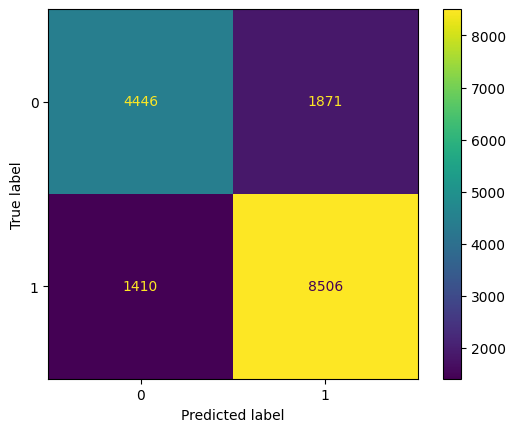

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import random

warnings.filterwarnings("ignore")

# ✅ Seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ✅ Features and target
y = kick['state_binary']
feature_cols = [
    'country_displayable_name', 'prelaunch_activated', 'staff_pick',
    'parent_category', 'duration', 'log_preparation_days', 'quarter',
    'log_creator_backing_count', 'has_video', 'log_goal_usd', 'gender',
    'blurb_word_count', 'name_word_count'
]
X = kick[feature_cols].copy()

# ✅ Train/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED
)

# ✅ Preprocessing
numeric_features = [
    'log_goal_usd', 'duration', 'log_preparation_days',
    'log_creator_backing_count', 'blurb_word_count', 'name_word_count'
]
bool_features = ['prelaunch_activated', 'staff_pick', 'has_video']
categorical_features = ['country_displayable_name', 'parent_category', 'gender', 'quarter']

preprocessor = ColumnTransformer([
    ('num',   StandardScaler(),        numeric_features),
    ('bool',  'passthrough',           bool_features),
    ('cat',   OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

# ✅ Model pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=SEED))
])

# ✅ Hyperparameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

# ✅ Nested CV on train_val
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

f1_scores, auc_scores, best_params_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='f1',
        cv=inner_cv,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    print(f"✅ Fold {fold+1}: F1 = {f1:.4f}, AUC = {auc:.4f}")
    f1_scores.append(f1)
    auc_scores.append(auc)
    best_params_list.append(clf.best_params_)

# ✅ CV summary
print("\n⭐ Final Nested CV Results")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average ROC-AUC Score: {np.mean(auc_scores):.4f}")

# Select best fold
best_fold_idx = int(np.argmax(f1_scores))
best_C = best_params_list[best_fold_idx]['clf__C']

print(f"\n📌 Using params from fold {best_fold_idx+1} (F1={f1_scores[best_fold_idx]:.4f}): C = {best_C}")

# ✅ Retrain final model
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(C=best_C, max_iter=1000, random_state=SEED))
])
final_model.fit(X_train_val, y_train_val)

# ✅ Final evaluation on test set
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# Metrics
f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_proba)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print("\n🧪 Final Evaluation on Held-Out Test Set")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test AUC Score: {auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n🔍 Confusion Matrix:")
print(cm)

ConfusionMatrixDisplay(cm).plot()